## Lista1 - Machine Learning
### Aluno: Valdiclei Costa Marinho
### Aluno: Renan Lemes Leepkaln


Objetivo: treinar um modelo de classificação utilizando o modelo de regressão Logística e árvore de decisão.


Banco utilizado: Detecção de doenças no fígado.


[Link](https://drive.google.com/file/d/1jnLwuv4e_ZeCqluMXs3Mar2TGetumtVv/view?usp=drive_link) para o banco


Descrição do banco:
> Este banco contém registro de 416 pacientes diagnosticados com doença no fígado e 167 pacientes sem. Esta informação está na coluna Selector.
>
> Há 10 variáveis no banco:
>
> * age: idade
> * Gender: gênero do paciente
> * TB: Bilirrubina total
> * DB: Bilirrubina direta
> * Alkphos: fosfatase alcalina.
> * Sgpt: transaminase glutâmico-pirúvica sérica (TGP)
> * Sgot: transaminase glutâmico-oxalacética sérica (TGO)
> * TP: Proteína total
> * ALB: Albumina
> * A/G Ratio: Relação Albumina:Globulina


Exercício:


1. Carregue o banco de dados e analise suas features. Transforme a feature sexo em uma variavel dummy.

2. Separe o banco em 80% para treino e 20% para teste.

3. Treine um modelo de regressão logística.    
    3.1 Interprete dois coeficientes.
    
4. Treine um modelo de árvore de decisão. Utilize max_depth de 4.    
    4.1 Quais são as duas features mais importantes?
  
5. Construa um relatório dos dois modelos. 
    5.1 Tomando como decisão a precisão para detectar doença no fígado qual é o melhor modelo?    
    5.2 Tomando como decisão o f1 score do rótulo de pacientes com doença no fígado qual é o melhor modelo?


Obs.: Utilize o **mesmo** banco de treino e de teste para construir e avaliar os dois modelos.

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss, mean_squared_error, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import math

## 1. Carga do banco
--------------------

In [2]:
df = pd.read_csv('Indian Liver Patient Dataset (ILPD).csv')
df.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
df.describe().round()

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
count,583.0,583.0,583.0,583.0,583.0,583.0,583.0,583.0,579.0,583.0
mean,45.0,3.0,1.0,291.0,81.0,110.0,6.0,3.0,1.0,1.0
std,16.0,6.0,3.0,243.0,183.0,289.0,1.0,1.0,0.0,0.0
min,4.0,0.0,0.0,63.0,10.0,10.0,3.0,1.0,0.0,1.0
25%,33.0,1.0,0.0,176.0,23.0,25.0,6.0,3.0,1.0,1.0
50%,45.0,1.0,0.0,208.0,35.0,42.0,7.0,3.0,1.0,1.0
75%,58.0,3.0,1.0,298.0,60.0,87.0,7.0,4.0,1.0,2.0
max,90.0,75.0,20.0,2110.0,2000.0,4929.0,10.0,6.0,3.0,2.0


In [4]:
print("total de linhas:", df.shape[0])

total de linhas: 583


In [5]:
print("total de colunas:", df.shape[1])

total de colunas: 11


#### Verifica valores ausentes

In [6]:
df[df.isna().any(axis=1)]

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
209,45,Female,0.9,0.3,189,23,33,6.6,3.9,NaN,1
241,51,Male,0.8,0.2,230,24,46,6.5,3.1,NaN,1
253,35,Female,0.6,0.2,180,12,15,5.2,2.7,NaN,2
312,27,Male,1.3,0.6,106,25,54,8.5,4.8,NaN,2


In [7]:
df[['A/G Ratio']].isna().sum().sort_index()/len(df)

A/G Ratio    0.006861
dtype: float64

In [8]:
df = df.dropna(how='any')

#### Criar variáveis dummy para 'Gender'

In [9]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [10]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

#### Lista columns por dtype

In [11]:
columns_by_dtype = {}
for col, dtype in df.dtypes.items():
    if dtype not in columns_by_dtype:
        columns_by_dtype[dtype] = [col]
    else:
        columns_by_dtype[dtype].append(col)

# Imprimir as colunas agrupadas por tipo de dados
for dtype, columns in columns_by_dtype.items():
    print(f"{dtype}: {columns}")
    print()

int64: ['Age', 'Gender', 'Alkphos', 'Sgpt', 'Sgot', 'Selector']

float64: ['TB', 'DB', 'TP', 'ALB', 'A/G Ratio']



### Matrix de Correlação
- Como as variáveis comportamentais estão relacionadas com a detecção de doenças no fígado?
- Como as variáveis de comportamento estão relacionadas entre si?

In [12]:
behavioral_vars = df
correlation_matrix = behavioral_vars.corr()

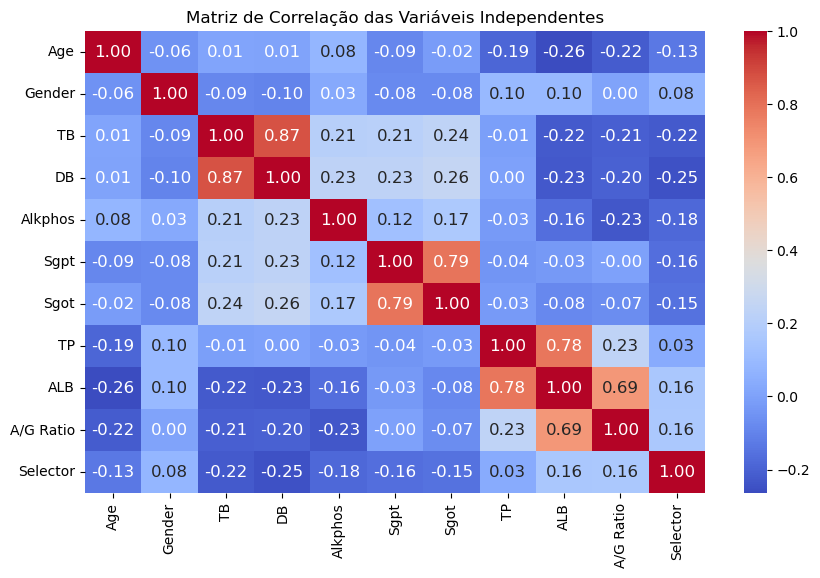

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
plt.title('Matriz de Correlação das Variáveis Independentes')
plt.show()

#### Classificação das correlações em relação a variável dependente

In [14]:
def classificar_correlacao(correlacao):
    if abs(correlacao) >= 0.7:
        return 'Forte'
    elif abs(correlacao) >= 0.3:
        return 'Moderada'
    else:
        return 'Fraca' 

In [15]:
corr_matrix = df.corr(numeric_only=True)
    
for variavel, correlacao in corr_matrix['Selector'].sort_values(ascending=False).items():
    classificacao = classificar_correlacao(correlacao)
    print(f'{variavel}: {correlacao:.6f} - {classificacao}')

Selector: 1.000000 - Forte
A/G Ratio: 0.163131 - Fraca
ALB: 0.159770 - Fraca
Gender: 0.081349 - Fraca
TP: 0.033614 - Fraca
Age: -0.133164 - Fraca
Sgot: -0.151834 - Fraca
Sgpt: -0.163117 - Fraca
Alkphos: -0.183363 - Fraca
TB: -0.220218 - Fraca
DB: -0.246273 - Fraca


- **A/G Ratio (0.163131) e ALB (0.159770):**
Ambas têm correlações fracas, mas positivas, com Selector. A correlação positiva indica que, à medida que uma dessas variáveis aumenta, a probabilidade do resultado (ou a classificação em Selector) também aumenta. No entanto, com correlações abaixo de 0.2, é improvável que esses valores tenham uma influência significativa no resultado.

- **Gender (0.081349), TP (0.033614):**
Correlações muito fracas ou quase inexistentes, indicando que essas variáveis provavelmente não têm uma influência significativa no resultado.

- **Age (-0.133164):**
Uma correlação fraca e negativa com Selector. Isso sugere que, à medida que a idade aumenta, a probabilidade do resultado (ou a classificação) diminui. No entanto, a correlação é fraca, indicando uma influência leve.

- **Sgot (-0.151834), Sgpt (-0.163117), Alkphos (-0.183363), TB (-0.220218), DB (-0.246273):**
Estas variáveis apresentam correlações negativas e fracas com Selector, indicando que aumentos nessas variáveis estão associados a uma redução na probabilidade do resultado (ou mudança na classificação). Como a correlação é fraca, a influência não é significativa.

Como todas as correlações (exceto a do próprio Selector) são fracas, isso pode indicar que essas variáveis têm pouca influência significativa sobre a variável alvo.

#### Separar recursos e variável alvo

In [16]:
X = df.drop('Selector', axis=1)
y = df['Selector']

#### Transformação em valores binários

In [17]:
y = (y == 1).astype(int)  # Transforma em 0 ou 1

#### Verificar a distribuição das classes

In [18]:
class_counts = y.value_counts()
print("Distribuição das classes:")
print(class_counts)

Distribuição das classes:
Selector
1    414
0    165
Name: count, dtype: int64


Conjunto de dados desequilibrado, resultado uma acurácia enganosa. Desta forma, usaremos métricas como precisão, recall, F1-Score e matriz de confusão para entender melhor o desempenho do modelo em cada classe.

#### Dividir em conjuntos de treinamento e teste (80% para treino e 20% para teste)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Treinamento do Modelo de Regressão Logística
--------------------

In [21]:
import statsmodels.api as sm
# Adiciona uma constante à matriz de características para calcular o termo de interceptação do modelo
X = sm.add_constant(X)

# Ajusta o modelo de regressão logística
model = sm.Logit(y, X)
result = model.fit()

# Imprime os coeficientes de regressão e os valores p associados
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.490445
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               Selector   No. Observations:                  579
Model:                          Logit   Df Residuals:                      568
Method:                           MLE   Df Model:                           10
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                  0.1793
Time:                        00:12:15   Log-Likelihood:                -283.97
converged:                       True   LL-Null:                       -346.00
Covariance Type:            nonrobust   LLR p-value:                 7.525e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5737      1.333     -2.681      0.007      -6.186      -0.961
Age            0.0183      0.

#### Extrair os coeficientes do resumo

In [22]:
coeficients = result.params
coeficients.sort_values(ascending=False)

A/G Ratio    1.808051
TP           0.927382
DB           0.449684
Age          0.018292
Sgpt         0.011930
TB           0.011227
Sgot         0.002473
Alkphos      0.001270
Gender      -0.030993
ALB         -1.695139
const       -3.573650
dtype: float64

#### Extrair os valores P (p-values) do resumo

In [23]:
p_values = result.pvalues
p_values.sort_values(ascending=True)

Age          0.004132
const        0.007343
TP           0.015043
Sgpt         0.019334
ALB          0.023452
DB           0.062592
A/G Ratio    0.113017
Alkphos      0.115941
Sgot         0.428009
Gender       0.894111
TB           0.897243
dtype: float64

In [24]:
def avaliar_significancia(p_values, alpha=0.05):
    significativos = []
    nao_significativos = []
    
    # Iterar sobre os valores P
    for variavel, p_valor in p_values.items():
        # Verificar se o p-valor é menor que o nível de significância (alpha)
        if p_valor < alpha:
            significativos.append(variavel)
        else:
            nao_significativos.append(variavel)
    
    return significativos, nao_significativos

In [25]:
significativos, nao_significativos = avaliar_significancia(p_values)
print("Variáveis com p-values significativos:", significativos)
print()
print("Variáveis com p-values não significativos:", nao_significativos)

Variáveis com p-values significativos: ['const', 'Age', 'Sgpt', 'TP', 'ALB']

Variáveis com p-values não significativos: ['Gender', 'TB', 'DB', 'Alkphos', 'Sgot', 'A/G Ratio']


### Simplificação do Modelo

In [28]:
# Dividir os dados em variáveis independentes (X) e variável dependente (y)
X = df[['Age', 'Sgpt', 'TP', 'ALB']]
y = df['Selector']

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padroniza os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Cria e ajusta o modelo de regressão multinomial
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_scaled, y_train)

# Probabilidades do conjunto de teste
y_pred_proba = model.predict_proba(X_test_scaled)

# Predição dos resultados do conjunto de teste
y_pred = model.predict(X_test_scaled)

# Avaliação da precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo:", accuracy)
print()

# Calcular o MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print()

# Calcular o RMSE
rmse = math.sqrt(mse)
print("Root Mean Squared Error:", rmse)
print()

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)
print()

# Relatório de Classificação
class_report = classification_report(y_test, y_pred)
print("Relatório de Classificação:")
print(class_report)
print()

# Identificar os índices onde o modelo errou
error_indices = np.where(y_test != y_pred)[0]

#Coeficientes do modelo
coeficientes = model.coef_
intercepto = model.intercept_

Acurácia do modelo: 0.6293103448275862

Mean Squared Error: 0.3706896551724138

Root Mean Squared Error: 0.608842882172744

Matriz de Confusão:
[[71  2]
 [41  2]]

Relatório de Classificação:
              precision    recall  f1-score   support

           1       0.63      0.97      0.77        73
           2       0.50      0.05      0.09        43

    accuracy                           0.63       116
   macro avg       0.57      0.51      0.43       116
weighted avg       0.58      0.63      0.51       116




### Interpretação dois coeficientes.

**Acurácia**: A acurácia (accuracy) é a proporção de previsões corretas em relação ao total de previsões. A acurácia do modelo é cerca de 0.629, ou seja, 62,93%. Isso significa que o modelo está acertando aproximadamente 63% das previsões.

**Matriz de Confusão**: A matriz de confusão ajuda a visualizar como o modelo se saiu para cada classe:

- True Positives (TP): Previsões corretas para a classe 1 (71).
- True Negatives (TN): Previsões corretas para a classe 2 (2).
- False Positives (FP): Previsões erradas para a classe 1 que deveriam ser classe 2 (2).
- False Negatives (FN): Previsões erradas para a classe 2 que deveriam ser classe 1 (41).

A matriz mostra que o modelo está identificando bem a classe 1, mas não está identificando corretamente a classe 2.

**Relatório de Classificação**
O relatório de classificação fornece métricas mais detalhadas para cada classe:

-**Precision**: A precisão para a classe 1 é 0.63, significando que das previsões feitas para essa classe, 63% estavam corretas. Para a classe 2, a precisão é 0.50.

-**Recall**: O recall para a classe 1 é 0.97, indicando que o modelo identifica 97% dos verdadeiros exemplos da classe 1. Para a classe 2, o recall é apenas 0.05, indicando que apenas 5% dos verdadeiros exemplos dessa classe foram identificados corretamente.

-**F1-Score**:
O F1-Score é a média harmônica entre precisão e recall. O F1-Score para a classe 1 é 0.77, e para a classe 2 é 0.09, indicando que o modelo tem dificuldade em lidar com a classe 2.

-**Macro e Weighted Average**:
O macro average calcula a média entre as classes, tratando cada classe igualmente, enquanto o weighted average considera o tamanho de cada classe. Os valores baixos para essas métricas indicam uma discrepância entre o desempenho nas diferentes classes.

**Conclusões**
O modelo parece ter bom desempenho para a classe 1, mas um desempenho fraco para a classe 2. Isso pode ser devido a um desequilíbrio nas classes, problemas de overfitting ou características inadequadas para separar as classes.

Para melhorar o desempenho do modelo, você pode considerar:

Rebalanceamento das Classes: Usar técnicas como sobremostragem ou subamostragem para equilibrar as classes.
Ajuste de Hiperparâmetros: Experimentar com diferentes configurações do modelo.
Recursos Adicionais: Incluir mais variáveis relevantes para ajudar o modelo a distinguir entre as classes.

#### Log Loss

In [29]:
logloss = log_loss(y_test, y_pred_proba)
print("Log Loss:", round(logloss, 4))
print()

Log Loss: 0.5958



In [30]:
print("Coeficientes do modelo:")
print(model.coef_.round(2))
print("Intercepto do modelo:")
print(model.intercept_.round(2))
print()

Coeficientes do modelo:
[[-0.14 -1.56 -0.3   0.34]]
Intercepto do modelo:
[-0.85]



Quanto cada variável contribui para o log-odds de 'Seletor' ocorrer?

- **Coeficiente** -0.14:
Indica uma relação inversa com a variável alvo. Aumentos nesta variável estão associados a uma diminuição na probabilidade do resultado.

- **Coeficiente** -1.56:
Sugere uma relação inversa significativa.

- **Coeficiente** -0.3:
Indica uma relação inversa com menor efeito.

- **Coeficiente** 0.34:
Este coeficiente positivo sugere uma relação direta com a variável alvo. À medida que a variável aumenta, a probabilidade do resultado também aumenta.

- **Intercepto**
Um intercepto negativo como [-0.85] sugere uma baixa probabilidade do resultado quando todas as variáveis estão zeradas.

#### Interpretando os coeficientes em termos de odds

In [31]:
print("Interpretação dos Coeficientes em termos de Odds:")
print("Intercepto (Constante):")
print("Odds Basais:", np.exp(model.intercept_)[0])
print()

for i, feature in enumerate(X.columns):
    print(f"Coeficiente para '{feature}':")
    print(f"Odds Ratio: {np.exp(model.coef_[0][i]):.2f}")
    print()

Interpretação dos Coeficientes em termos de Odds:
Intercepto (Constante):
Odds Basais: 0.427081205144902

Coeficiente para 'Age':
Odds Ratio: 0.87

Coeficiente para 'Sgpt':
Odds Ratio: 0.21

Coeficiente para 'TP':
Odds Ratio: 0.74

Coeficiente para 'ALB':
Odds Ratio: 1.41



#### Razão entre probabilidade de sucesso e probabilidade de fracasso

- **Intercepto (Constante)**
Odds Basais: 0.427221171000031
Isso significa que, quando todas as outras variáveis são mantidas constantes (ou seja, quando todos os valores são zero), a chance do resultado positivo (como a presença de doença hepática) é de aproximadamente 0.427. 

- **Coeficiente para 'Age'**
Odds Ratio: 0.87
Um odds ratio de 0.87 sugere que, para cada unidade adicional de idade, a chance de o resultado ser positivo é cerca de 0.87 vezes a chance anterior. Em outras palavras, cada ano a mais na idade reduz as chances do resultado positivo em 13%. Portanto, à medida que a idade aumenta, a probabilidade de o resultado ser positivo diminui.

- **Coeficiente para 'Sgpt'**
Odds Ratio: 0.21
Um odds ratio de 0.21 indica que, para cada unidade de aumento em Sgpt, a chance de o resultado ser positivo é reduzida para 21% da chance anterior. Isso sugere que, se o nível de Sgpt aumenta, a chance de um resultado positivo cai significativamente, indicando uma relação inversa forte entre Sgpt e o resultado.

- **Coeficiente para 'TP'**
Odds Ratio: 0.74
Um odds ratio de 0.74 significa que, para cada unidade adicional de proteína total (TP), a chance do resultado positivo é aproximadamente 74% da chance anterior. Isso implica que um aumento nos níveis de proteína total reduz ligeiramente a probabilidade do resultado positivo.

- **Coeficiente para 'ALB'**
Odds Ratio: 1.41
Um odds ratio de 1.41 significa que, para cada unidade adicional de albumina (ALB), a chance do resultado positivo é 1.41 vezes a chance anterior. Isso sugere uma relação direta entre os níveis de albumina e a probabilidade do resultado positivo, indicando que níveis mais altos de albumina aumentam a chance do resultado positivo.

- **Conclusões**
Odds Ratios Menores que 1: Indicariam que a variável está associada a uma redução nas chances do resultado positivo. Por exemplo, Age, Sgpt, e TP estão nessa categoria.
Odds Ratios Maiores que 1: Indicariam que a variável está associada a um aumento nas chances do resultado positivo. ALB é um exemplo.

#### Função para calcular as probabilidades de classe

In [32]:
def calculate_probabilities(model, X):
    probabilities = model.predict_proba(X)
    classes = model.classes_
    result = pd.DataFrame(probabilities, columns=[f'prob_{class_}' for class_ in classes])
    return result

# Probabilidades de classe para os dados de teste
probabilities = calculate_probabilities(model, X_test_scaled)
print("\nProbabilidades de classe para os dados de teste:")
print("\nA classe 0 (classe negativa ou Não-evento)")
print("A classe 1 (classe positiva ou Evento)")
probabilities.head()


Probabilidades de classe para os dados de teste:

A classe 0 (classe negativa ou Não-evento)
A classe 1 (classe positiva ou Evento)


,prob_1,prob_2
0,0.751057,0.248943
1,0.810367,0.189633
2,0.612649,0.387351
3,0.714409,0.285591
4,0.729840,0.270160


- **Linha 0:**
Com uma probabilidade de 0.750977 para a classe 1 e 0.249023 para a classe 2, o modelo prevê que há uma chance de cerca de 75% de ser da classe 1 e 25% de ser da classe 2. Com uma diferença significativa, essa previsão parece relativamente segura em relação à classe 1.

- **Linha 1:**
Com uma probabilidade de 0.810337 para a classe 1 e 0.189663 para a classe 2, a previsão é mais forte para a classe 1, com uma probabilidade de 81% contra 19%. Novamente, parece uma previsão confiável para a classe 1.

- **Linha 2:**
As probabilidades são 0.612777 para a classe 1 e 0.387223 para a classe 2. Aqui, a diferença entre as probabilidades é menor, indicando que o modelo está um pouco menos certo em sua previsão, mas ainda favorece a classe 1.

- **Linha 3:**
Com uma probabilidade de 0.714364 para a classe 1 e 0.285636 para a classe 2, o modelo prevê uma maior chance de ser da classe 1, mas com menos confiança do que a Linha 1.

- **Linha 4:**
As probabilidades são 0.729783 para a classe 1 e 0.270217 para a classe 2. A diferença é significativa, indicando que o modelo prevê uma maior probabilidade para a classe 1, mas com uma margem de incerteza maior do que em algumas previsões anteriores.

### 4. Treinamento do Modelo de Árvore de Decisão com max_depth de 4
--------------------

#### Dividir em conjuntos de treinamento e teste (80% para treino e 20% para teste)

In [35]:
#sc_X = StandardScaler()
#X_train = sc_X.fit_transform(X_train)
#X_test = sc_X.transform(X_test)

#### Treinar modelo de Árvore de Decisão com max_depth=4

In [33]:
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

#### Pegando a importância das features

In [36]:
feature_importances = tree_clf.feature_importances_

feature_names = X_train.columns
feature_names

Index(['Age', 'Sgpt', 'TP', 'ALB'], dtype='object')

#### Cria um dataframe para visualizar a importância das features

In [37]:
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Ordenar por importância para ver quais são as mais importantes
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
1,Sgpt,0.606658
3,ALB,0.201784
0,Age,0.160251
2,TP,0.031307


#### Plotar a árvore para visualizar a estrutura

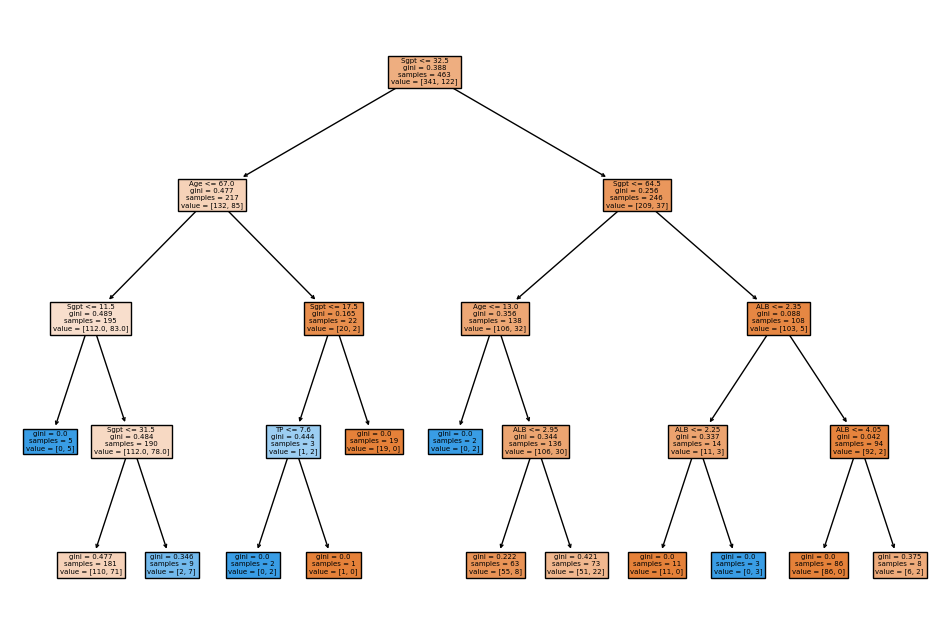

In [38]:
plt.figure(figsize=(12, 8))
plot_tree(tree_clf, feature_names=feature_names, filled=True)
plt.show()

#### Avaliação do desempenho no conjunto de teste para Árvore de Decisão

In [39]:
y_pred_tree_clf = tree_clf.predict(X_test)
print("Desempenho do modelo de árvore de decisão:")
print(classification_report(y_test, y_pred_tree_clf))
print("Matriz de Confusão da Árvore de Decisão:")
print(confusion_matrix(y_test, y_pred_tree_clf))

Desempenho do modelo de árvore de decisão:
              precision    recall  f1-score   support

           1       0.65      0.97      0.78        73
           2       0.67      0.09      0.16        43

    accuracy                           0.65       116
   macro avg       0.66      0.53      0.47       116
weighted avg       0.65      0.65      0.55       116

Matriz de Confusão da Árvore de Decisão:
[[71  2]
 [39  4]]


#### Desempenho do Modelo:

**Precisão (precision):** Proporção de previsões corretas dentro das classificações positivas que o modelo fez.
- Classe 1: 0.65
- Classe 2: 0.67

O modelo é relativamente preciso para ambas as classes, mas a precisão pode ser enganosa se a distribuição dos dados for desequilibrada.

**Recall:** Mede a capacidade do modelo de identificar todas as amostras positivas.
- Classe 1: 0.97
- Classe 2: 0.09

O recall para a Classe 1 é muito alto, indicando que o modelo conseguiu identificar a maioria das amostras desta classe. No entanto, para a Classe 2, o recall é muito baixo, o que sugere que muitas amostras desta classe não foram identificadas pelo modelo.

**F1-score:** A média harmônica entre precisão e recall.
- Classe 1: 0.78
- Classe 2: 0.16
O f1-score para a Classe 1 é bom, mas para a Classe 2 é bastante baixo, indicando que a capacidade do modelo para a classe 2 é bem inferior.

**Acurácia (accuracy):** Reflete a proporção total de previsões corretas.
A acurácia geral é 0.65, sugerindo que o modelo está acertando 65% das vezes.
Matriz de Confusão:
- Classe 1: O modelo previu 71 corretos e 2 incorretos, indicando um desempenho forte para esta classe.
- Classe 2: O modelo teve 39 falsos negativos e apenas 4 verdadeiros positivos, indicando um desempenho muito fraco para esta classe.


**Análise Geral:**
O desempenho do modelo está bastante enviesado para a Classe 1, possivelmente devido ao desequilíbrio de dados ou à escolha do critério de divisão da árvore. O baixo recall para a Classe 2 é um problema significativo, pois indica que o modelo tem dificuldade em identificar corretamente as instâncias dessa classe.

## 5.1 Qual modelo escolhido olhando para a precisão de detecção de doença no fígado?
--------------------

**Análise:**

- **Classe 1:**
A árvore de decisão apresenta uma precisão mais alta (0.65) em comparação com a regressão logística (0.63).

- **Classe 2:**
A árvore de decisão também mostra uma precisão superior (0.67) em relação à regressão logística (0.50).

**Considerações:**

O modelo que parece ter maior precisão global é a Árvore de Decisão. Com base nas informações, ela demonstra melhor desempenho tanto para a Classe 1 quanto para a Classe 2. Porém é essencial considerar outros aspectos além da precisão, como recall, F1-score, e as implicações dos falsos positivos e falsos negativos.

Como os dados são desbalanceados, a precisão por si só pode ser enganosa, sendo necessário avaliar a performance do modelo com outras métricas ou até com validação cruzada.

## 5.2 Qual modelo escolhido olhando para o f1-score do rótulo de doença do fígado?
--------------------

**Análise**
Ambos os modelos têm um desempenho ruim para a Classe 2, apresentando um F1-score muito baixo (0.09). Portanto, nenhum deles é realmente eficaz em predizer a Classe 2.

No entanto, há uma diferença significativa para a Classe 1:

Modelo 1 tem um F1-score de 0.77 para a Classe 1.
Modelo 2 tem um F1-score de 0.97 para a Classe 1.
Isso indica que o Modelo 2 é mais eficiente para a Classe 1, alcançando quase a pontuação perfeita, enquanto o Modelo 1 tem um desempenho consideravelmente menor para a mesma classe. Assim, se a classe 1 for a principal preocupação, o Modelo 2 seria a escolha superior.

**Considerações**

Como há um desequilíbrio entre as classes, o  F1-score pode refletir essa discrepância. 

As baixas pontuações para a Classe 2 em ambos os modelos indicam que talvez seja necessário reequilibrar os dados ou usar técnicas como amostragem, pesos de classe ou algoritmos que lidam melhor com desbalanceamento.

**Necessidade de melhorias:** Dado que ambos os modelos apresentam desempenho muito baixo para a Classe 2, pode ser necessário:
- Revisar a abordagem de modelagem
- Coletar mais dados para melhorar o aprendizado do modelo para essa classe.
